In [419]:
import torch
import numpy as np
from matplotlib import pyplot as plt


# Условия задачи
$$
s^2 \sum_i^n\left(\frac{x_i}{s}-\operatorname{sign}\left(\frac{x_i}{s}\right)\right)^2 \rightarrow \min _s
$$


$$
f(x,s)  = s^2 \sum_i^n\left(\frac{x_i}{s}-\operatorname{sign}\left(\frac{x_i}{s}\right)\right)^2 = \sum_i^n\left(x_{i}-s * \operatorname{sign}\left(\frac{x_i}{s}\right)\right)^2  = \sum_i^n\left(x_{i}^2-2 x_{i} s * \operatorname{sign}\left(\frac{x_i}{s}\right) + (s * \operatorname{sign}\left(\frac{x_i}{s})\right)^2\right)
$$


в силу определения sign(х) и без рассмотрения точки 0
$$ (\operatorname{sign}\left(\frac{x_i}{s}\right)  )^2= 1$$ 


пусть S>0, при S=0 у нас деление на 0 и функция не определена в этой точке
для получения точного аналитического решения ищем точку экстремума
$$\frac{\partial f}{\partial s} = 0$$

$$\frac{\partial f}{\partial s} = \sum_i^n\left(-2 x_{i}  \operatorname{sign}\left({x_i}\right) + 2s\right) = \sum_i^n\left(-2|x_{i}| + 2s\right)$$

 $$\sum_i^n\left(-2|x_{i}| + 2s\right) = \sum_i^n\left(-2|x_{i}|\right) +2sn = 0$$

$$s = \frac{\sum_i^n\left(|x_{i}|\right)}{n} $$

аналогично для случая S<0 получается 
$$s = -\frac{\sum_i^n\left(|x_{i}|\right)}{n} $$

In [420]:
mu, sigma, n, s = 0, 1, 100, 1 # параметры нормального распределения, количество сэмплированных точек и начальное приближение S, чтобы избежать деления на 0
sample = np.random.normal(mu, sigma, n)
s_min1 = np.sum(abs(sample))/n
s_min2 = -np.sum(abs(sample))/n

def f(x, s): # исходная функция
    return np.sum((x- s * np.sign(x/s))**2)

if f(sample,s_min1) == f(sample,s_min2):
    print('Минимальное значение функции: ' + str(f(sample,s_min1) ))
    print('Значения S, при котором достигается минимум: ' + str(s_min1) + ' и ' +  str(s_min2))
else:
    print('Минимальное значение функции: ' + str(np.min([f(sample,s_min1),f(sample,s_min2) ])))
    print('Значение S, при котором достигается минимум: ' + str([s_min1,s_min2][np.argmin([f(sample,s_min1),f(sample,s_min2)] )]))


Минимальное значение функции: 36.62463422765314
Значения S, при котором достигается минимум: 0.8435083371089821 и -0.8435083371089821


# основная идея градиентного спуска

$$s_{i+1} = s_{i} - \frac{\partial f}{\partial s}(s_{i}) * LearningRate$$

$$f(x,s) = \sum_i^n\left(x_{i}^2-2 x_{i} s * \operatorname{sign}\left(\frac{x_i}{s}\right) + (s * \operatorname{sign}\left(\frac{x_i}{s})\right)^2\right)$$


# В условиях просили переопределить нахождение прозводной $sign(\frac{x_i} {s})$
## Линейный случай
$$
  \frac{\partial [  sign \left(\frac{x_i} {s} \right)] }{\partial s} = \frac{\partial [\frac{x_i} {s}]}{\partial s} = \frac{-x_i} {s^2}
$$

## Случай гиперболического тангенса
$$
  \frac{\partial [  sign \left(\frac{x_i} {s} \right)]}{\partial s} = \frac{\partial tanh[\frac{x_i} {s}]}{\partial s} =( 1 - tanh^{2}[\frac{x_i} {s}])* (\frac{-x_i} {s^2}) = \frac{\frac{-x_i} {s^2}}{cosh^2(x)}
$$

$$\frac{\partial f}{\partial s} = \sum_i^n\left(-2 x_{i}  \operatorname{sign}\left({\frac{x_i}{s}}\right) + 2x_{i}s\frac{-x_{i}}{s^2}+2s\right) $$

так же учтено и не вычислялась производная
$$ (\operatorname{sign}\left(\frac{x_i}{s}\right)  )^2= 1 $$ 


In [421]:
class SignLinearFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input, weight):
        ctx.save_for_backward(input, weight)
        output = torch.sign(input/weight)
        return output

    @staticmethod
    def backward(ctx, grad_output):
        input, weight = ctx.saved_tensors
        grad_input = 1/weight
        grad_weight = -input/(weight**2)
        return  grad_weight  , grad_input

linearSign = SignLinearFunction.apply


Минимальное значение функции 36.624661817648025
Минимальное значение функции достигается при s=0.843858540058136


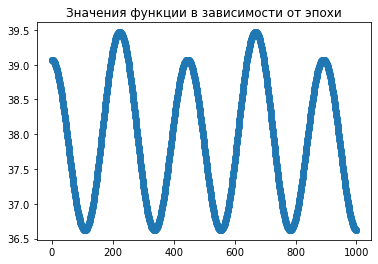

In [422]:
learning_rate = 1e-6
n_epoch = 1000
loss_history, s_history = [], []
loss_min,s_best = None, None
x = torch.from_numpy(sample)
s = torch.tensor([1.], requires_grad= True)

for epoch in range(n_epoch):
    loss = ((x- s * linearSign(x, s)).pow(2)).sum()
    loss.backward()
    s.data -= learning_rate * s.grad.data
    loss_history.append(loss.data)
    s_history.append(s)

    if loss_min == None or loss<loss_min:
        loss_min = loss
        s_best = s

plt.scatter(range(n_epoch),loss_history)
plt.title('Значения функции в зависимости от эпохи')
print('Минимальное значение функции '+str(loss_min.item()))
print('Минимальное значение функции достигается при s='+str(s_best.item()))


In [423]:
class SignTanhFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input, weight):
        ctx.save_for_backward(input, weight)
        output = torch.sign(input/weight)
        return output

    @staticmethod
    def backward(ctx, grad_output):

        input, weight = ctx.saved_tensors
        grad_input = 1./weight
        grad_weight = -input/((weight**2)*torch.cosh(input/weight))

        return  grad_weight  , grad_input

TanhSign = SignTanhFunction.apply


Минимальное значение функции 36.624661817648025
Минимальное значение функции достигается при s=0.843858540058136


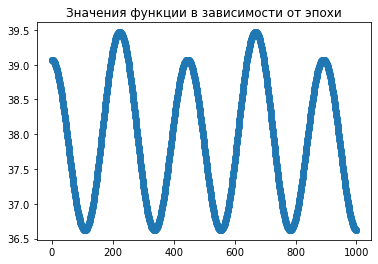

In [424]:
learning_rate = 1e-6
n_epoch = 1000
loss_history, s_history = [], []
loss_min,s_best = None, None
x = torch.from_numpy(sample)
s = torch.tensor([1.], requires_grad= True)

for epoch in range(n_epoch):
    loss = ((x- s * TanhSign(x, s)).pow(2)).sum()
    loss.backward()
    s.data -= learning_rate * s.grad.data
    loss_history.append(loss.data)
    s_history.append(s)

    if loss_min == None or loss<loss_min:
        loss_min = loss
        s_best = s

plt.scatter(range(n_epoch),loss_history)
plt.title('Значения функции в зависимости от эпохи')
print('Минимальное значение функции '+str(loss_min.item()))
print('Минимальное значение функции достигается при s='+str(s_best.item()))

# Ответы для случая градиентного спуска совпадают и достаточно близки по значению к точному аналитическому решению
## очевидно, что переопределив вычисление производной мы сами сдвинули экстремум, поэтому идеального попадания в аналитическое решение не добиться

In [425]:
torch.cosh(x/s_best).mean()

tensor(2.1480, dtype=torch.float64, grad_fn=<MeanBackward0>)

# величина порядка 2, т.е. вносит изменения на на масштабе 1000 эпох этого почти не заметно

# Так же знак найденного S зависит от начальных условий для случаев градиентного спуска